In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.metrics import average_precision_score, precision_recall_curve, PrecisionRecallDisplay, auc, roc_curve

# 2D model

In [2]:
ground_truth_path = r"D:/deepfakes/data/test/labels.csv"
results_path = r"D:/deepfakes/src/inference/predictions/final_efficient_net4.csv"

In [3]:
target_names = ["REAL", "FAKE"]

In [4]:
results = pd.read_csv(results_path)

In [5]:
results

,filename,label
0,4000.mp4,0.990000
1,4001.mp4,0.990000
2,4002.mp4,0.990000
3,4003.mp4,0.569241
4,4004.mp4,0.017729
...,...,...
3995,7995.mp4,0.063486
3996,7996.mp4,0.070172
3997,7997.mp4,0.022141
3998,7998.mp4,0.951619


## Prepare Data for evaluation

In [6]:
ground_truth = pd.read_csv(ground_truth_path)

In [7]:
ground_truth

,filename,label
0,4000.mp4,1
1,4001.mp4,1
2,4002.mp4,1
3,4003.mp4,0
4,4004.mp4,0
...,...,...
3995,7995.mp4,0
3996,7996.mp4,0
3997,7997.mp4,0
3998,7998.mp4,1


In [8]:
truth_labels = ground_truth["label"].values
predicted_labels = results["label"].values

In [12]:
assert len(truth_labels) == len(predicted_labels)

# Loss

In [13]:
loss = log_loss(truth_labels, predicted_labels)
loss

0.42375272005997183

# Average Precision and ROC

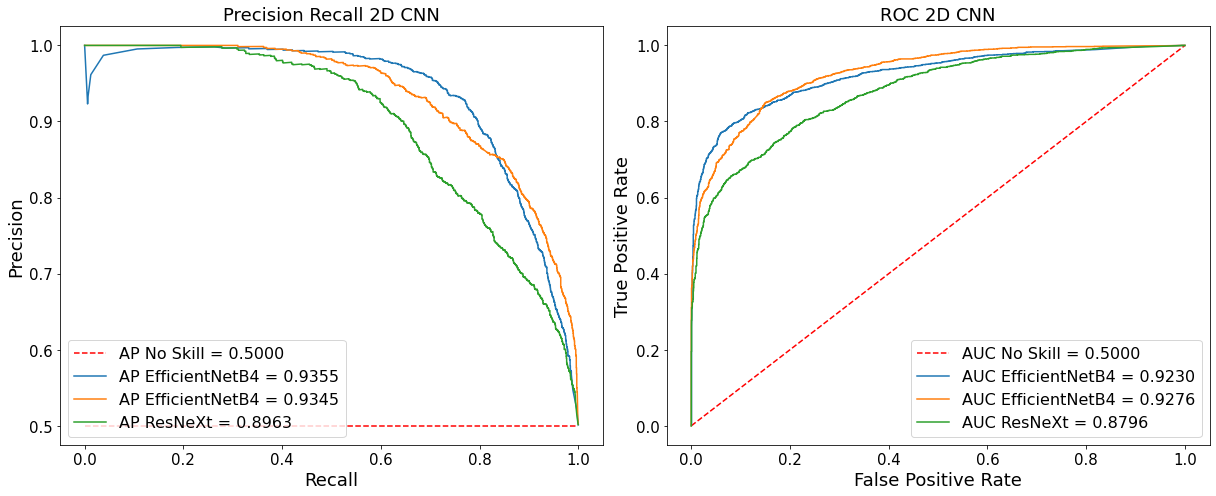

In [31]:
Random_2D_Path = r"D:\deepfakes\src\inference\predictions\scores_efficient_net4_dropoutrandom.csv"
predicted_labels_2D_DropRandom = pd.read_csv(Random_2D_Path).label.values

Resnet = r"D:\deepfakes\src\inference\predictions\scores_resnext.csv"
predicted_labels_2D_Resnet = pd.read_csv(Resnet).label.values

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))
# plt.tick_params(axis='both', which='minor', labelsize=18)

# Precision Recall
average_precision = average_precision_score(truth_labels, predicted_labels)
precision, recall, _ = precision_recall_curve(truth_labels, predicted_labels)
average_precision_random = average_precision_score(truth_labels, predicted_labels_2D_DropRandom)
precision_random, recall_random, _ = precision_recall_curve(truth_labels, predicted_labels_2D_DropRandom)
average_precision_resnext = average_precision_score(truth_labels, predicted_labels_2D_Resnet)
precision_resnext, recall_resnext, _ = precision_recall_curve(truth_labels, predicted_labels_2D_Resnet)
no_skill = 0.5
ax1.set_title("Precision Recall 2D CNN", fontsize=18)
ax1.plot([0, 1], [no_skill, no_skill], 'r--', linestyle='--', label='AP No Skill = %0.4f' % 0.5)
ax1.plot(recall, precision, label = 'AP EfficientNetB4 = %0.4f' % average_precision)
ax1.plot(recall_random, precision_random, label = 'AP EfficientNetB4 = %0.4f' % average_precision_random)
ax1.plot(recall_resnext, precision_resnext, label = 'AP ResNeXt = %0.4f' % average_precision_resnext)
ax1.legend(loc = 'lower left', prop={'size': 16})
ax1.set_ylabel('Precision', fontsize=18)
ax1.set_xlabel('Recall', fontsize=18)
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)


# ROC
fpr, tpr, threshold = roc_curve(truth_labels, predicted_labels)
roc_auc = auc(fpr, tpr)
fpr_random, tpr_random, threshold_random = roc_curve(truth_labels, predicted_labels_2D_DropRandom)
roc_auc_random = auc(fpr_random, tpr_random)
fpr_resnext, tpr_resnext, threshold_resnext = roc_curve(truth_labels, predicted_labels_2D_Resnet)
roc_auc_resnext = auc(fpr_resnext, tpr_resnext)
ax2.set_title('ROC 2D CNN', fontsize=18)
ax2.plot([0, 1], [0, 1],'r--', label='AUC No Skill = %0.4f' % 0.5)
ax2.plot(fpr, tpr, label = 'AUC EfficientNetB4 = %0.4f' % roc_auc)
ax2.plot(fpr_random, tpr_random, label = 'AUC EfficientNetB4 = %0.4f' % roc_auc_random)
ax2.plot(fpr_resnext, tpr_resnext, label = 'AUC ResNeXt = %0.4f' % roc_auc_resnext)
ax2.legend(loc = 'best', prop={'size': 16})
ax2.set_ylabel('True Positive Rate', fontsize=18)
ax2.set_xlabel('False Positive Rate', fontsize=18)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)

# plt.subplot_tool()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=2)
fig.tight_layout()
# plt.savefig('Final2DCNN.png', dpi=300, bbox_inches='tight')
# plt.show()

In [16]:
# change to zeros and 1s
for i in range(len(predicted_labels)):
    if predicted_labels[i] > 0.5:
        predicted_labels[i] = 1
    else:
        predicted_labels[i] = 0

In [17]:
cm = confusion_matrix(truth_labels, predicted_labels)

In [18]:
cm

array([[1915,   85],
       [ 550, 1450]], dtype=int64)

<AxesSubplot:>

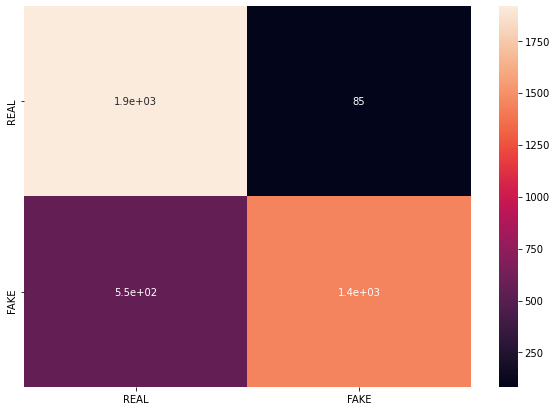

In [19]:
df_cm = pd.DataFrame(cm, index = target_names,
                  columns = target_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [20]:
print("Classification report for deepfake classifier:\n%s\n"
      % (classification_report(truth_labels, predicted_labels, target_names=target_names)))

Classification report for deepfake classifier:
              precision    recall  f1-score   support

        REAL       0.78      0.96      0.86      2000
        FAKE       0.94      0.72      0.82      2000

    accuracy                           0.84      4000
   macro avg       0.86      0.84      0.84      4000
weighted avg       0.86      0.84      0.84      4000




# 3D model

In [12]:
results_3D_cloud = r"D:/deepfakes/src/inference/predictions/scores_efficient_net4_3D_cloud.csv"

In [10]:
df_3D_cloud = pd.read_csv(results_3D_cloud)
predicted_labels_3D_cloud = df_3D_cloud["prediction"].values

df_3D = pd.read_csv(r"D:/deepfakes/src/inference/scores_3D_local.csv")
predicted_labels_3D = df_3D["prediction"].values

In [13]:
loss_3D_model = log_loss(truth_labels, predicted_labels_3D)
loss_3D_model

0.46969100692039706

In [14]:
loss_3D_model_cloud = log_loss(truth_labels, predicted_labels_3D_cloud)
loss_3D_model_cloud

0.39703016674362784

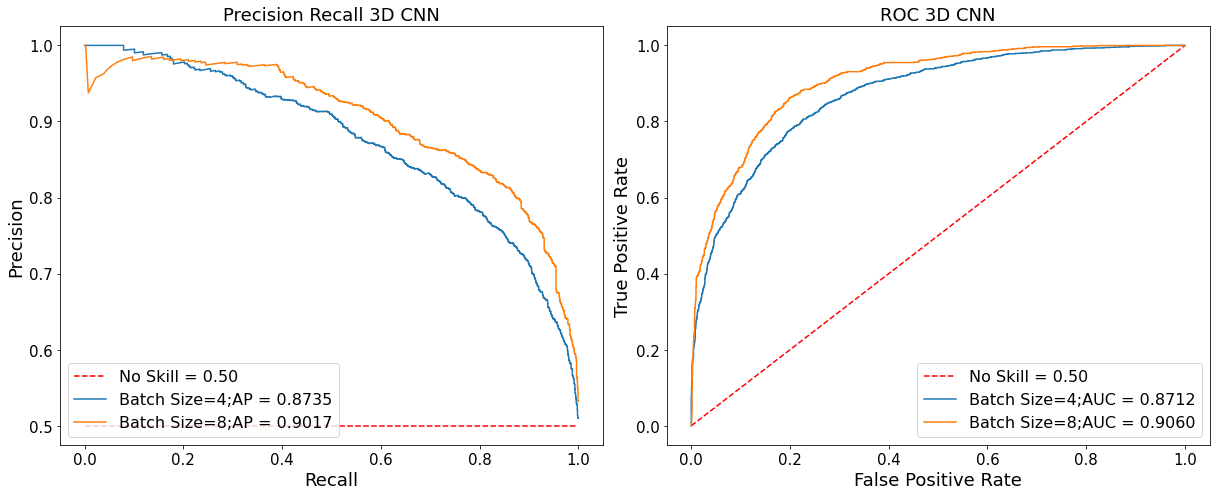

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))
# plt.tick_params(axis='both', which='minor', labelsize=18)

# Precision Recall
average_precision = average_precision_score(truth_labels, predicted_labels_3D)
precision, recall, _ = precision_recall_curve(truth_labels, predicted_labels_3D)
average_precision_cloud = average_precision_score(truth_labels, predicted_labels_3D_cloud)
precision_cloud, recall_cloud, _ = precision_recall_curve(truth_labels, predicted_labels_3D_cloud)
no_skill = 0.5
ax1.set_title("Precision Recall 3D CNN", fontsize=18)
ax1.plot([0, 1], [no_skill, no_skill], 'r--', linestyle='--', label='No Skill = %0.2f' % 0.5)
ax1.plot(recall, precision, label = 'Batch Size=4;AP = %0.4f' % average_precision)
ax1.plot(recall_cloud, precision_cloud, label = 'Batch Size=8;AP = %0.4f' % average_precision_cloud)
ax1.legend(loc = 'lower left', prop={'size': 16})
ax1.set_ylabel('Precision', fontsize=18)
ax1.set_xlabel('Recall', fontsize=18)
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)

# ROC
fpr, tpr, threshold = roc_curve(truth_labels, predicted_labels_3D)
roc_auc = auc(fpr, tpr)
fpr_cloud, tpr_cloud, threshold = roc_curve(truth_labels, predicted_labels_3D_cloud)
roc_auc_cloud = auc(fpr_cloud, tpr_cloud)
ax2.set_title('ROC 3D CNN', fontsize=18)
ax2.plot([0, 1], [0, 1],'r--', label='No Skill = %0.2f' % 0.5)
ax2.plot(fpr, tpr, label = 'Batch Size=4;AUC = %0.4f' % roc_auc)
ax2.plot(fpr_cloud, tpr_cloud, label = 'Batch Size=8;AUC = %0.4f' % roc_auc_cloud)
ax2.legend(loc = 'lower right', prop={'size': 16})
ax2.set_ylabel('True Positive Rate', fontsize=18)
ax2.set_xlabel('False Positive Rate', fontsize=18)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)

# plt.subplot_tool()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=2)
fig.tight_layout()
plt.savefig('EfficientNet3DCombined.png', dpi=300, bbox_inches='tight')
# plt.show()

In [28]:
# change to zeros and 1s
for i in range(len(predicted_labels_3D)):
    if predicted_labels_3D[i] > 0.5:
        predicted_labels_3D[i] = 1
    else:
        predicted_labels_3D[i] = 0

In [29]:
cm = confusion_matrix(truth_labels, predicted_labels_3D)

<AxesSubplot:>

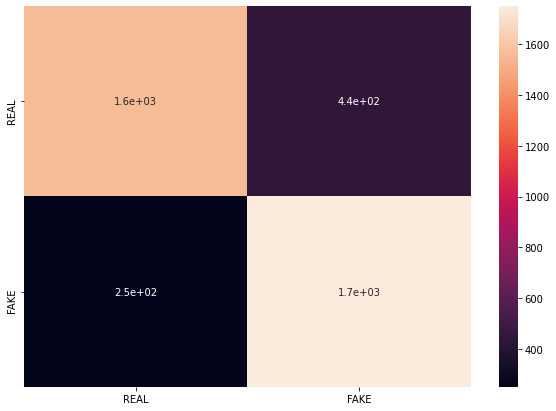

In [30]:
df_cm = pd.DataFrame(cm, index = target_names,
                  columns = target_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [31]:
print("Classification report for deepfake classifier:\n%s\n"
      % (classification_report(truth_labels, predicted_labels, target_names=target_names)))

Classification report for deepfake classifier:
              precision    recall  f1-score   support

        REAL       0.78      0.96      0.86      2000
        FAKE       0.94      0.72      0.82      2000

    accuracy                           0.84      4000
   macro avg       0.86      0.84      0.84      4000
weighted avg       0.86      0.84      0.84      4000




## Combine

In [39]:
Random_2D_Path = r"D:\deepfakes\src\inference\predictions\scores_efficient_net4_dropoutrandom.csv"

predicted_labels_3D = pd.read_csv(results_3D_cloud).prediction.values
predicted_labels_2D = pd.read_csv(results_path).label.values
predicted_labels_2D_DropRandom = pd.read_csv(Random_2D_Path).label.values

In [40]:
combined_labels = (predicted_labels_2D + predicted_labels_3D + predicted_labels_2D_DropRandom) / 3

In [41]:
combined_labels

array([0.99000009, 0.9897513 , 0.98701743, ..., 0.01649987, 0.94668355,
       0.99000005])

In [42]:
loss_combined = log_loss(truth_labels, combined_labels)
# This is very good result
loss_combined

0.29882826481055486

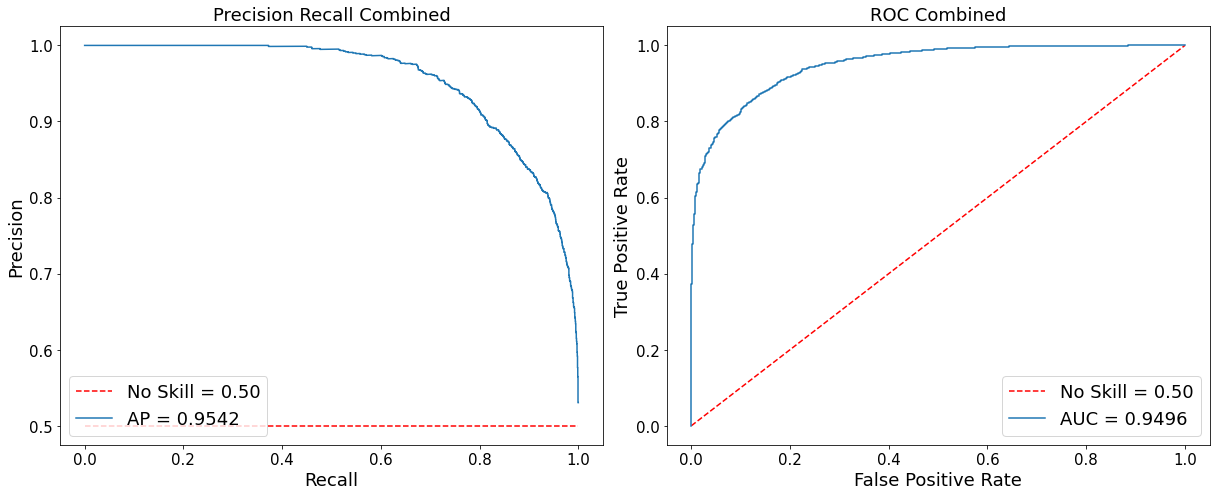

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))
# plt.tick_params(axis='both', which='minor', labelsize=18)

# Precision Recall
average_precision = average_precision_score(truth_labels, combined_labels)
precision, recall, threshold_precision = precision_recall_curve(truth_labels, combined_labels)
no_skill = 0.5
ax1.set_title("Precision Recall Combined", fontsize=18)
ax1.plot([0, 1], [no_skill, no_skill], 'r--', linestyle='--', label='No Skill = %0.2f' % 0.5)
ax1.plot(recall, precision, label = 'AP = %0.4f' % average_precision)
ax1.legend(loc = 'lower left', prop={'size': 18})
ax1.set_ylabel('Precision', fontsize=18)
ax1.set_xlabel('Recall', fontsize=18)
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)

# ROC
fpr, tpr, threshold_auc = roc_curve(truth_labels, combined_labels)
roc_auc = auc(fpr, tpr)
ax2.set_title('ROC Combined', fontsize=18)
ax2.plot([0, 1], [0, 1],'r--', label='No Skill = %0.2f' % 0.5)
ax2.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc)
ax2.legend(loc = 'lower right', prop={'size': 18})
ax2.set_ylabel('True Positive Rate', fontsize=18)
ax2.set_xlabel('False Positive Rate', fontsize=18)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)

# plt.subplot_tool()
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=2)
fig.tight_layout()
# plt.savefig('Combined_Final.png', dpi=300, bbox_inches='tight')
# plt.show()

In [44]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold_auc[optimal_idx]
print(optimal_threshold)

0.415995707


In [21]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
optimal_f_threshold = threshold_precision[ix]
print('Best Threshold=%f, F-Score=%.4f' % (threshold_precision[ix], fscore[ix]))

Best Threshold=0.331078, F-Score=0.8688


In [45]:
# change to zeros and 1s
for i in range(len(combined_labels)):
    if combined_labels[i] > optimal_threshold:
        combined_labels[i] = 1
    else:
        combined_labels[i] = 0

In [23]:
cm = confusion_matrix(truth_labels, combined_labels)

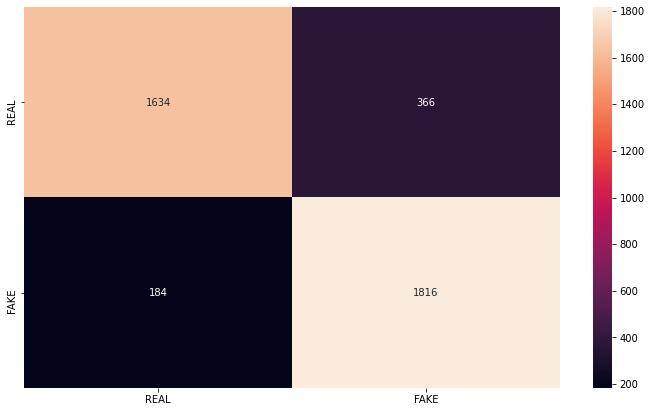

In [26]:
df_cm = pd.DataFrame(cm, index = target_names,
                  columns = target_names)
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('Heatmap_Precision.png', dpi=300)

In [45]:
print("Classification report for deepfake classifier:\n%s\n"
      % (classification_report(truth_labels, combined_labels, target_names=target_names)))

Classification report for deepfake classifier:
              precision    recall  f1-score   support

        REAL       0.82      0.92      0.86      2000
        FAKE       0.91      0.79      0.85      2000

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000




In [25]:
print("Classification report for deepfake classifier:\n%s\n"
      % (classification_report(truth_labels, combined_labels, target_names=target_names)))

Classification report for deepfake classifier:
              precision    recall  f1-score   support

        REAL       0.90      0.82      0.86      2000
        FAKE       0.83      0.91      0.87      2000

    accuracy                           0.86      4000
   macro avg       0.87      0.86      0.86      4000
weighted avg       0.87      0.86      0.86      4000




In [46]:
combined_labels

array([1., 1., 1., ..., 0., 1., 1.])

In [29]:
truth_labels

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [48]:
for i in range(len(combined_labels)):
    if combined_labels[i] != truth_labels[i] and truth_labels[i] == 1:
        print(i+4000)

4009
4045
4090
4091
4136
4154
4182
4186
4203
4230
4242
4250
4264
4265
4276
4301
4332
4341
4367
4372
4401
4404
4408
4424
4437
4449
4482
4506
4507
4517
4555
4566
4572
4587
4588
4594
4622
4640
4643
4651
4665
4690
4694
4703
4713
4724
4731
4744
4773
4787
4799
4832
4844
4848
4862
4864
4865
4880
4900
4912
4925
4931
4932
4934
4946
4948
4961
4965
4969
4986
4987
4992
4994
5013
5028
5038
5066
5070
5072
5089
5092
5175
5184
5191
5209
5219
5257
5265
5282
5292
5296
5308
5318
5339
5361
5369
5379
5395
5402
5408
5417
5424
5433
5467
5470
5480
5488
5493
5522
5554
5571
5573
5576
5578
5590
5598
5607
5638
5670
5734
5771
5774
5779
5787
5793
5811
5815
5832
5855
5859
5881
5884
5888
5906
5907
5953
5988
6002
6009
6014
6018
6050
6052
6053
6067
6087
6094
6116
6139
6141
6163
6176
6185
6190
6198
6217
6220
6279
6311
6344
6351
6369
6401
6405
6408
6424
6425
6430
6437
6448
6457
6478
6487
6489
6494
6517
6531
6550
6553
6560
6572
6573
6585
6612
6628
6630
6637
6643
6647
6661
6679
6694
6701
6730
6733
6749
6770
6781
6784
6786
